<a href="https://colab.research.google.com/github/excelasaph/beijing_time_series_forecasting/blob/main/Excel_Asaph_Time_Series_Air_Quality_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, GRU, BatchNormalization, Bidirectional, MultiHeadAttention, Add, LayerNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the datasets
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Exploring the training data


In [5]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [6]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

This is a list of all column names in the training DataFrame.
It confirms the exact set of features and the target variable ('pm2.5') available for modeling.

In [7]:
train.shape

(30676, 12)

In [8]:
test.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv'],
      dtype='object')

This is a list of all column names in the testing DataFrame.
Comparing this to the training column names, we see that the 'pm2.5' column is missing in the test set, as expected, because this is the target variable we need to predict

In [9]:
test.shape

(13148, 11)

In [10]:
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
datetime,0
cbwd_NW,0
cbwd_SE,0


This shows the number of missing (NaN) values for each column in the training DataFrame.

For most columns ('No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv'), the count is 0, indicating no missing values in these columns.


The 'pm2.5' column has a count of 1921, which means there are 1921 missing values in the target variable in the training set.

In [11]:
test.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
datetime,0
cbwd_NW,0
cbwd_SE,0


The count is 0 for all columns in the test DataFrame, indicating no missing values in these columns.

This is important as it means we don't need to handle missing values in the test features before making predictions.

In [12]:
train.describe()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


These statistics provide a summary of the central tendency, variability, and distribution of the numerical features and the target variable.

In [13]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

Here, I ensured that the 'datetime' column in both the training and test DataFrames is in the correct datetime format and then sets it as the DataFrame index.

# Visualizations

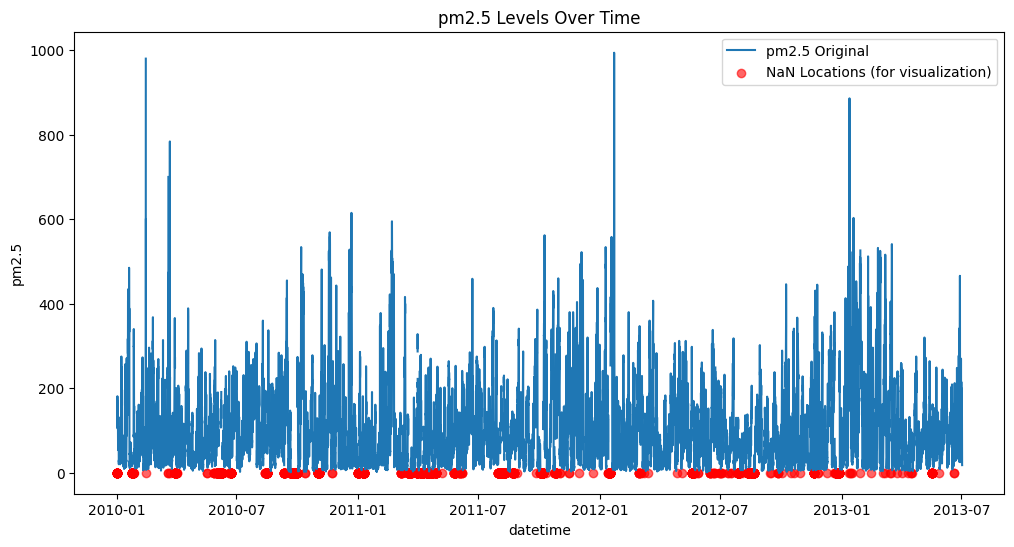

In [14]:
# Plotting the pm2.5 column to visualize the data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['pm2.5'], label='pm2.5 Original')

# Plotting the points where NaNs were to see where interpolation will happen
train_original = train.copy()
nan_indices = train_original[train_original['pm2.5'].isnull()].index
# Plotting at y=0 or some offset
plt.scatter(nan_indices, [0]*len(nan_indices), color='red', label='NaN Locations (for visualization)', alpha=0.6)

plt.title('pm2.5 Levels Over Time')
plt.xlabel('datetime')
plt.ylabel('pm2.5')
plt.legend()
plt.show()

From this plot, there appear to be periods of high and low pollution, indicating potential seasonality or other temporal patterns.

The `red dots` at the bottom of the plot represent the time points where the 'pm2.5' values were originally missing (NaNs) before any imputation. It shows the gaps in the original data that needed to be addressed during preprocessing.

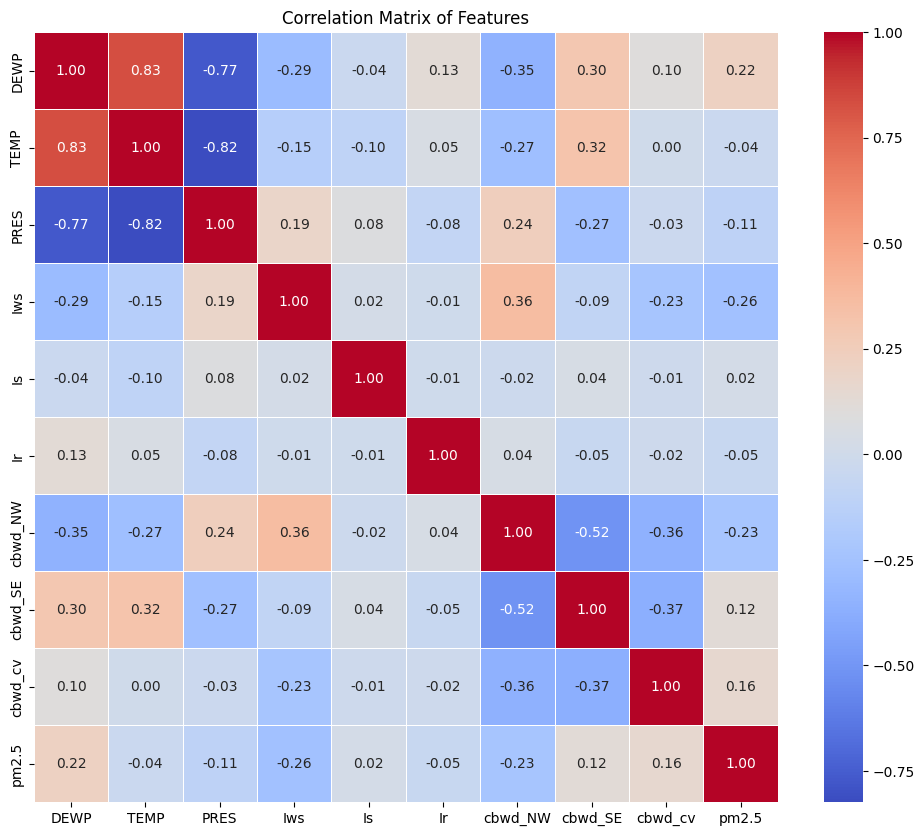

In [15]:
columns_for_correlation = train.drop(['No'], axis=1)

# Calculate the correlation matrix
correlation_matrix = columns_for_correlation.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.show()

This helps in understanding which features might be more influential in predicting 'pm2.5' and here are some correlations I observed from this heatmap:
- 'pm2.5' shows a moderate positive correlation with 'DEWP' and 'TEMP'.
- 'pm2.5' shows a weak negative correlation with 'PRES'.
- 'Iws', 'Is', and 'Ir' show very weak correlations with 'pm2.5'.
- Among features, 'DEWP' and 'TEMP' are strongly positively correlated.


# Preprocessing


## Handling missing values


- I consider Interpolation (specifically cubic spline) a good choice for filling missing values in time series data because it considers the trend and seasonality of the data to make more realistic estimations compared to simpler methods like filling with the mean or median.

In [16]:
train.interpolate(method='cubicspline', inplace=True)
test.interpolate(method='cubicspline', inplace=True)

train.bfill(inplace=True)
test.bfill(inplace=True)

In [17]:
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


After `interpolation and backward fill` have been applied, we can see that all the missing values were successfully imputed or filled, especially for the "pm2.5" column (our target variable)

In [18]:
test.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


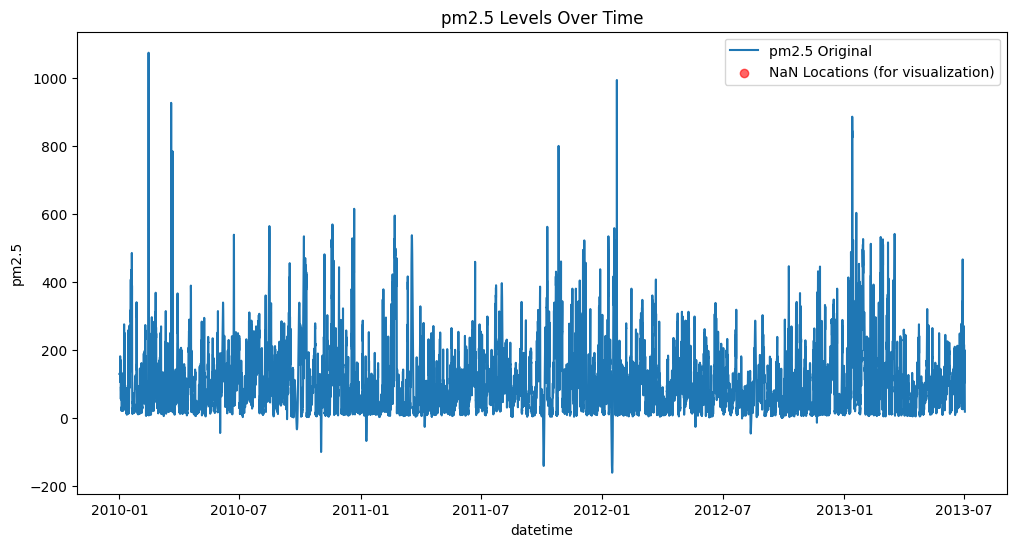

In [19]:
# Plotting the pm2.5 column to visualize the data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['pm2.5'], label='pm2.5 Original')

# Plotting the points where NaNs were to see where interpolation will happen
train_original = train.copy()
nan_indices = train_original[train_original['pm2.5'].isnull()].index
# Plotting at y=0 or some offset
plt.scatter(nan_indices, [0]*len(nan_indices), color='red', label='NaN Locations (for visualization)', alpha=0.6)

plt.title('pm2.5 Levels Over Time')
plt.xlabel('datetime')
plt.ylabel('pm2.5')
plt.legend()
plt.show()

After handling missing values, we can see from our plot here that the red dots, which shows "pm2.5" missing values, have cleared up.

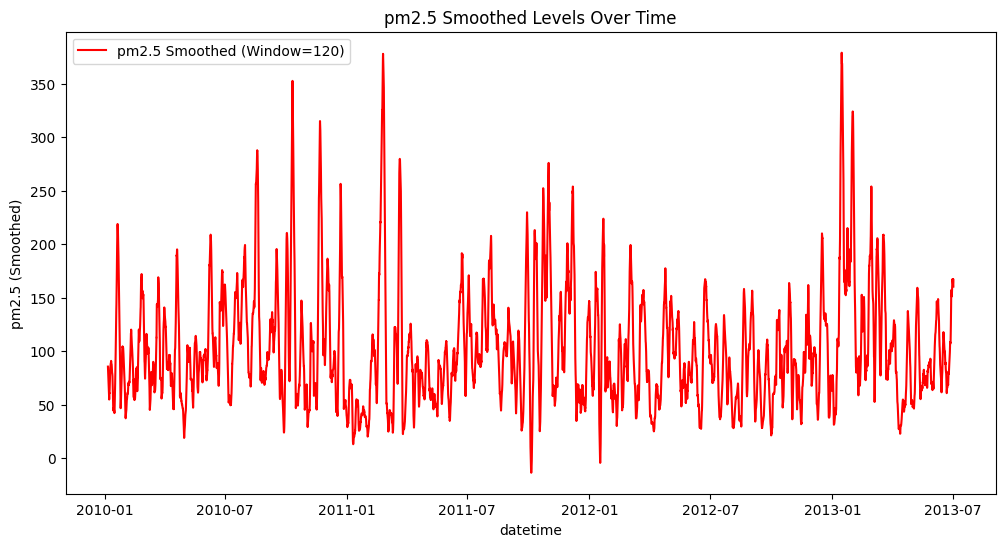

In [20]:
window_size = 120

pm25_smoothed = train['pm2.5'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(pm25_smoothed.index, pm25_smoothed, label=f'pm2.5 Smoothed (Window={window_size})', color='red')

plt.title('pm2.5 Smoothed Levels Over Time')
plt.xlabel('datetime')
plt.ylabel('pm2.5 (Smoothed)')
plt.legend()
plt.show()

The purpose of smoothing is to reduce noise and highlight the underlying long-term trends or seasonality in the time series data.

Compared to the original plot, this smoothed plot makes it easier to see the broader patterns of increasing and decreasing pollution levels without the hour-to-hour fluctuations.

## Separate features and target

Here the input features ('DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv') are seperated from our target variable (pm2.5)

In [21]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
X_test = test.drop(['No'], axis=1)
y_train = train['pm2.5']

In [22]:
X_train.columns

Index(['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv'],
      dtype='object')

In [23]:
X_test.columns

Index(['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv'],
      dtype='object')

In [24]:
X_train.shape

(30676, 9)

In [25]:
X_test.shape

(13148, 9)

In [26]:
y_train.shape

(30676,)

## Feature Engineering

**First**: the datetime index needs to be extracted from the input DataFrames. This is important for keeping track of the time component, especially for the test set to ensure predictions are aligned with the correct timestamps


**Second**: Pandas DataFrames/Series are converted into NumPy arrays. Neural networks, especially those in TensorFlow/Keras, typically work with NumPy arrays.


**Next**: Handle Length Mismatch: We check to ensure that the number of samples in the training features (X_train) and the training target (y_train) are the same. This is necessary before creating sequences.


`MinMaxScaler` is used here to scale the features (X_train, X_test) and the target (y_train) to a range between 0 and 1. Separate scalers are used for features and the target because the scaling is applied differently (fitting on training data and transforming both training and test).

## Input-Output Sequences using Time Windowing

- I experimented with sequence lengths of 12, 24, and 48 hours to find the optimal time window for capturing trends and potentially reducing the `RMSE score`.



In [27]:
def preprocess_data(X_train, y_train, X_test, seq_length=12, val_split=0.2):
    """
    Preprocessing the time series data by scaling features and targets, creating sequences of length 12.
    """
    # Extracting datetime index
    train_datetime = X_train.index if isinstance(X_train, pd.DataFrame) else None
    test_datetime = X_test.index if isinstance(X_test, pd.DataFrame) else None

    # Converting to NumPy arrays and drop datetime index if present
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()

    # Converting y_train to NumPy array if it's a pandas Series
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()

    # Checking and aligning lengths of X_train and y_train
    if len(X_train) != len(y_train):
        print(f"Warning: Length mismatch between X_train ({len(X_train)}) and y_train ({len(y_train)}).")
        print("Trimming to match lengths to avoid errors.")
        min_len = min(len(X_train), len(y_train))
        X_train = X_train[:min_len]
        y_train = y_train[:min_len]
        if train_datetime is not None:
            train_datetime = train_datetime[:min_len]
    else:
        print(f"X_train and y_train lengths are consistent: {len(X_train)} samples.")

    # Initializing scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Scaling input features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scaling target values (only for training data)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

    # Combining scaled training and test data for sequence continuity
    combined_scaled = np.vstack((X_train_scaled, X_test_scaled))
    combined_y_scaled = np.vstack((y_train_scaled, np.zeros((len(X_test_scaled), 1))))

    # Creating training sequences
    n_features = X_train_scaled.shape[1]
    train_sequences = []
    train_targets = []
    for i in range(len(X_train_scaled) - seq_length + 1):
        seq = X_train_scaled[i:i + seq_length]
        target = y_train_scaled[i + seq_length - 1]  # Target is y_12 (for sequence of length 12)
        train_sequences.append(seq)
        train_targets.append(target)
    train_sequences = np.array(train_sequences)
    train_targets = np.array(train_targets)

    # Extending test data with the last 11 rows of training for continuity
    overlap_rows = X_train_scaled[- (seq_length - 1):]  # Last rows of training
    extended_test_scaled = np.vstack((overlap_rows, X_test_scaled))

    # Creating test sequences
    test_sequences = []
    test_datetimes = []
    for i in range(len(extended_test_scaled) - seq_length + 1):
        seq = extended_test_scaled[i:i + seq_length]
        test_sequences.append(seq)
        if test_datetime is not None:
            test_datetimes.append(test_datetime[i])

    test_sequences = np.array(test_sequences)
    test_datetimes = test_datetime.tolist() if test_datetime is not None else test_datetimes[-len(X_test_scaled):]
    test_sequences = test_sequences[-len(X_test_scaled):]  # Take the last 13,148 sequences

    # Validating lengths
    if len(test_sequences) != len(test_datetimes):
        raise ValueError(f"Mismatch between test sequences ({len(test_sequences)}) and test datetimes ({len(test_datetimes)}).")
    if len(test_sequences) != len(X_test_scaled):
        raise ValueError(f"Mismatch between test sequences ({len(test_sequences)}) and X_test ({len(X_test_scaled)}).")
    print(f"Number of test sequences: {len(test_sequences)}")
    print(f"Number of test datetimes: {len(test_datetimes)}")


    # Spliting training sequences into train and validation
    if len(train_sequences) == 0 or len(train_targets) == 0:
        raise ValueError("Not enough training sequences.")
    if len(train_sequences) < 2:
        raise ValueError("Insufficient training sequences for validation split.")
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
        train_sequences, train_targets, test_size=val_split, random_state=42, shuffle=False
    )

    X_test_seq = test_sequences

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y

We returned the prepared training, validation, and test sequences and targets, along with the fitted scalers needed for our model building

# Model 1 : LSTM Model `with Sequence Length 12`

In [45]:
def lstm_model_1(n_features, seq_length=12):
    """
    An LSTM model to predict scaled PM2.5 at the 12th timestep using h_12.
    """
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = LSTM(25, return_sequences=True, activation='tanh')(input_layer)
    lstm_out = LSTM(25, return_sequences=True, activation='tanh')(lstm_out)
    last_output= lstm_out[:, -1, :]
    final_output = Dense(1, activation='sigmoid')(last_output)  # Predict y_12 (scaled)

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001), loss='mse')
    # Display the model architecture
    model.summary()
    return model

In [46]:
# Calculating the Root Mean Squared Error (RMSE)
def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [47]:
# Preprocessing the data
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=12)

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148


In [48]:
# Adding callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [49]:
# Build and train the model
lstm_model = lstm_model_1(n_features=X_train_seq.shape[2], seq_length=12)
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50, batch_size=32, verbose=1,
    callbacks=[lr_scheduler]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 12, 25)         │         3,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 25)         │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item (GetItem)              │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,626 (33.70 KB)

 Trainable params: 8,626 (33.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0152 - val_loss: 0.0059 - learning_rate: 1.0000e-04
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0046 - val_loss: 0.0055 - learning_rate: 1.0000e-04
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0046 - val_loss: 0.0052 - learning_rate: 1.0000e-04
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0042 - val_loss: 0.0051 - learning_rate: 1.0000e-04
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0041 - val_loss: 0.0049 - learning_rate: 1.0000e-04
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0041 - val_loss: 0.0049 - learning_rate: 1.0000e-04
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0040 - val_loss: 0.0049 - learning_rate: 1.0000e-04
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0042 - val_loss: 0.0048 - learning_rate: 1.0000e-04
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0041 - val

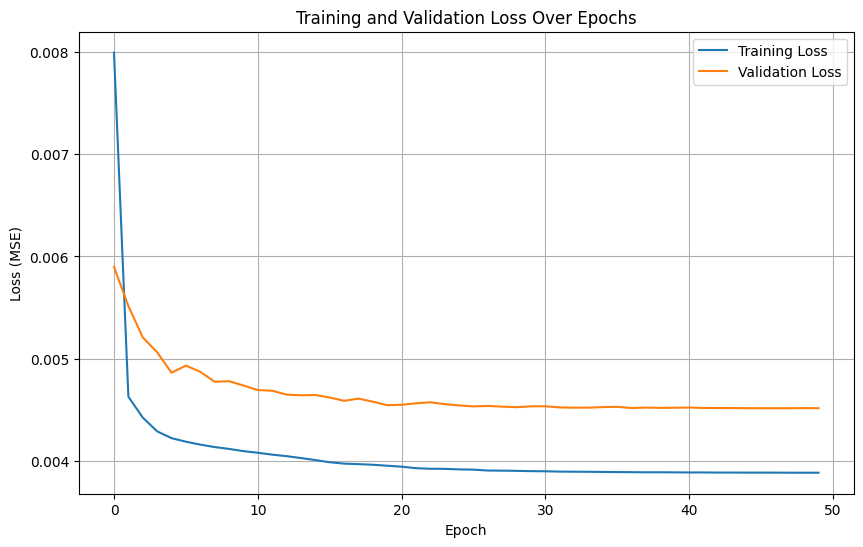

In [50]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Inference on test set with batch prediction
y_pred_scaled = lstm_model.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensuring predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/lstm_model_12seq.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/lstm_model_12seq.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/lstm_model_12seq.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 10:00:00, Predicted PM2.5 = 72
Sample 2: Datetime = 2013-07-02 11:00:00, Predicted PM2.5 = 68
Sample 3: Datetime = 2013-07-02 12:00:00, Predicted PM2.5 = 63
Sample 4: Datetime = 2013-07-02 13:00:00, Predicted PM2.5 = 61
Sample 5: Datetime = 2013-07-02 14:00:00, Predicted PM2.5 = 59


# Model 2 : LSTM Model `with Sequence Length 48`

In [52]:
def lstm_model_2(n_features, seq_length=48):
    """
    An LSTM model to predict scaled PM2.5 at the last timestep using its hidden state.
    """
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = LSTM(50, return_sequences=True, activation='tanh', kernel_initializer=tf.keras.initializers.LecunNormal(seed=21))(input_layer)
    lstm_out = LSTM(50, return_sequences=True, activation='tanh')(lstm_out)
    lstm_out = tf.keras.layers.BatchNormalization()(lstm_out)
    last_output = lstm_out[:, -1, :]  # Hidden state of the last timestep
    final_output = Dense(1, activation='sigmoid')(last_output)  # Predict scaled target

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00001), loss='mse')
    # Display the model architecture
    model.summary()
    return model

In [53]:
# Calculating the Root Mean Squared Error (RMSE)
def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [54]:
# Preprocessing the data
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=48)

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148


In [55]:
# Adding callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [56]:
# Build and train the model
lstm_model2 = lstm_model_2(n_features=X_train_seq.shape[2], seq_length=48)
history = lstm_model2.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50, batch_size=32, verbose=1,
    callbacks=[lr_scheduler]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 48, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 48, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item_1 (GetItem)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,451 (126.76 KB)

 Trainable params: 32,351 (126.37 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - loss: 0.0869 - val_loss: 0.0096 - learning_rate: 1.0000e-05
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - loss: 0.0101 - val_loss: 0.0071 - learning_rate: 1.0000e-05
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - loss: 0.0064 - val_loss: 0.0055 - learning_rate: 1.0000e-05
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - loss: 0.0051 - val_loss: 0.0049 - learning_rate: 1.0000e-05
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - loss: 0.0044 - val_loss: 0.0047 - learning_rate: 1.0000e-05
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - loss: 0.0043 - val_loss: 0.0045 - learning_rate: 1.0000e-05
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - loss: 0.0041 - val_loss: 0.0044 - learning_rate: 1.0000e-05
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - loss: 0.0042 - val_loss: 0.0043 - learning_rate: 1.0000e-05
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - loss: 0.0038 - v

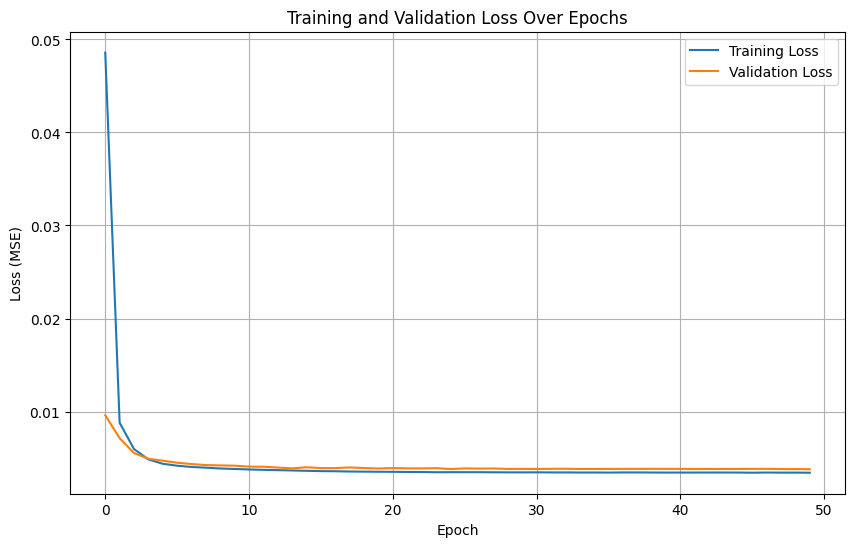

In [57]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# Inference on test set with batch prediction
y_pred_scaled = lstm_model2.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensuring predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/lstm_model_48seq.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/lstm_model_48seq.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/lstm_model_48seq.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 10:00:00, Predicted PM2.5 = 56
Sample 2: Datetime = 2013-07-02 11:00:00, Predicted PM2.5 = 47
Sample 3: Datetime = 2013-07-02 12:00:00, Predicted PM2.5 = 43
Sample 4: Datetime = 2013-07-02 13:00:00, Predicted PM2.5 = 42
Sample 5: Datetime = 2013-07-02 14:00:00, Predicted PM2.5 = 44


# Model 3 : GRU Model `with Sequence Length 48`

In [59]:
def gru_model_1(n_features, seq_length=48):
    """
    A GRU model to predict scaled PM2.5 at the last timestep using its hidden state.
    """
    input_layer = Input(shape=(seq_length, n_features))
    gru_out = tf.keras.layers.GRU(50, return_sequences=True, activation='tanh', kernel_initializer=tf.keras.initializers.LecunNormal(seed=21))(input_layer)
    gru_out = tf.keras.layers.GRU(50, return_sequences=True, activation='tanh')(gru_out)
    gru_out = tf.keras.layers.BatchNormalization()(gru_out)
    last_output = gru_out[:, -1, :]  # Hidden state of the last timestep
    final_output = Dense(1, activation='sigmoid')(last_output)  # Predict scaled target

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00001), loss='mse')
    # Display model architecture
    model.summary()
    return model

In [60]:
# Calculating the Root Mean Squared Error (RMSE)
def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [61]:
# Preprocessing the data
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=48)

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148


In [62]:
# Adding callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [63]:
# Build and train the model
gru_model = gru_model_1(n_features=X_train_seq.shape[2], seq_length=48)
history = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50, batch_size=32, verbose=1,
    callbacks=[lr_scheduler]
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 48, 50)         │         9,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 48, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item_2 (GetItem)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,701 (96.49 KB)

 Trainable params: 24,601 (96.10 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 50s 60ms/step - loss: 0.0846 - val_loss: 0.0136 - learning_rate: 1.0000e-05
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 83s 61ms/step - loss: 0.0287 - val_loss: 0.0094 - learning_rate: 1.0000e-05
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 79s 58ms/step - loss: 0.0105 - val_loss: 0.0070 - learning_rate: 1.0000e-05
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - loss: 0.0060 - val_loss: 0.0056 - learning_rate: 1.0000e-05
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - loss: 0.0051 - val_loss: 0.0051 - learning_rate: 1.0000e-05
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - loss: 0.0047 - val_loss: 0.0048 - learning_rate: 1.0000e-05
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 85s 61ms/step - loss: 0.0045 - val_loss: 0.0047 - learning_rate: 1.0000e-05
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 80s 58ms/step - loss: 0.0044 - val_loss: 0.0047 - learning_rate: 1.0000e-05
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 81s 57ms/step - loss: 0.0042 - v

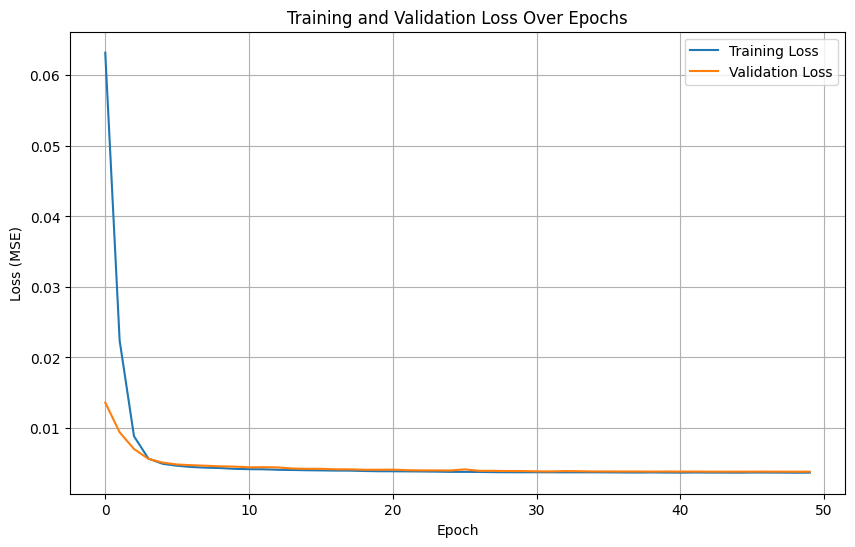

In [64]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# Inference on test set with batch prediction
y_pred_scaled = gru_model.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensuring predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/gru_model_48seq.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/gru_model_48seq.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/gru_model_48seq.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 10:00:00, Predicted PM2.5 = 75
Sample 2: Datetime = 2013-07-02 11:00:00, Predicted PM2.5 = 73
Sample 3: Datetime = 2013-07-02 12:00:00, Predicted PM2.5 = 74
Sample 4: Datetime = 2013-07-02 13:00:00, Predicted PM2.5 = 74
Sample 5: Datetime = 2013-07-02 14:00:00, Predicted PM2.5 = 71


# Model 4 : GRU Model `with Sequence Length 48 and Early Stopping`

In [66]:
def gru_model_2(n_features, seq_length=48):
    """
    A GRU model to predict scaled PM2.5 at the last timestep using its hidden state.
    """
    input_layer = Input(shape=(seq_length, n_features))
    gru_out = tf.keras.layers.GRU(50, return_sequences=True, activation='tanh', kernel_initializer=tf.keras.initializers.LecunNormal(seed=21))(input_layer)
    gru_out = tf.keras.layers.GRU(50, return_sequences=True, activation='tanh')(gru_out)
    gru_out = tf.keras.layers.BatchNormalization()(gru_out)
    last_output = gru_out[:, -1, :]  # Hidden state of the last timestep
    final_output = Dense(1, activation='sigmoid')(last_output)  # Predict scaled target

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00001), loss='mse')
    # Display model architecture
    model.summary()
    return model

In [67]:
# Calculating the Root Mean Squared Error (RMSE)
def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [68]:
# Preprocessing the data
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=48)

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148


In [69]:
# Adding callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [70]:
# Build and train the model
gru_model2 = gru_model_2(n_features=X_train_seq.shape[2], seq_length=48)
history = gru_model2.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50, batch_size=32, verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 48, 50)         │         9,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 48, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item_3 (GetItem)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,701 (96.49 KB)

 Trainable params: 24,601 (96.10 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - loss: 0.1096 - val_loss: 0.0263 - learning_rate: 1.0000e-05
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - loss: 0.0313 - val_loss: 0.0128 - learning_rate: 1.0000e-05
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 79s 57ms/step - loss: 0.0132 - val_loss: 0.0079 - learning_rate: 1.0000e-05
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - loss: 0.0072 - val_loss: 0.0061 - learning_rate: 1.0000e-05
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - loss: 0.0054 - val_loss: 0.0053 - learning_rate: 1.0000e-05
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - loss: 0.0048 - val_loss: 0.0049 - learning_rate: 1.0000e-05
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - loss: 0.0046 - val_loss: 0.0048 - learning_rate: 1.0000e-05
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 80s 58ms/step - loss: 0.0044 - val_loss: 0.0048 - learning_rate: 1.0000e-05
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - loss: 0.0044 - v

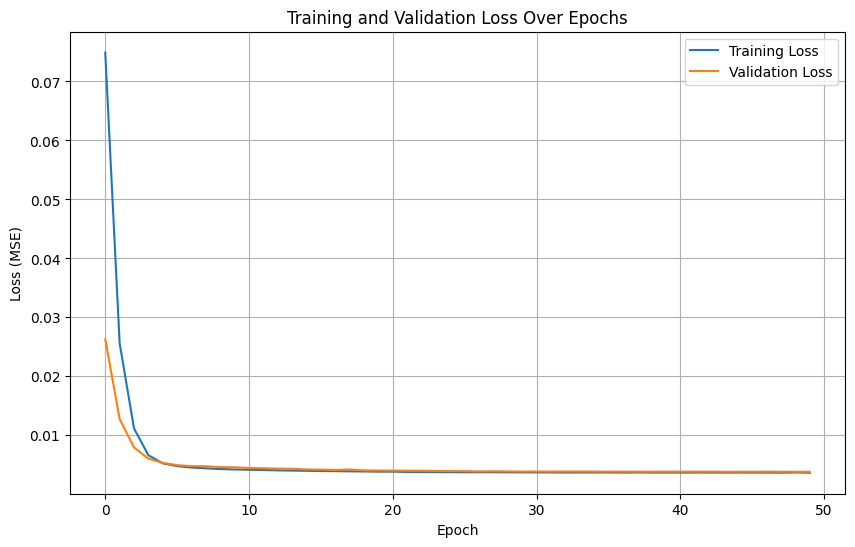

In [71]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
# Inference on test set with batch prediction
y_pred_scaled = gru_model2.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensuring predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/gru_model_48seq_earlystopping.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/gru_model_48seq_earlystopping.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/gru_model_48seq_earlystopping.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 10:00:00, Predicted PM2.5 = 89
Sample 2: Datetime = 2013-07-02 11:00:00, Predicted PM2.5 = 83
Sample 3: Datetime = 2013-07-02 12:00:00, Predicted PM2.5 = 83
Sample 4: Datetime = 2013-07-02 13:00:00, Predicted PM2.5 = 82
Sample 5: Datetime = 2013-07-02 14:00:00, Predicted PM2.5 = 78


# Model 5 : Bidirectional LSTM Model `with Sequence Length 48`

In [73]:
# A Bidirectional LSTM model
def bilstm_model_1(n_features, seq_length=48):
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh', kernel_initializer=tf.keras.initializers.LecunNormal(seed=21)))(input_layer)
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh'))(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    output_last = lstm_out[:, -1, :]
    final_output = Dense(1, activation='sigmoid')(output_last)

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00001), loss='mse')
    # Display model architecture
    model.summary()
    return model

In [74]:
# Calculating the Root Mean Squared Error (RMSE)
def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [75]:
# Preprocessing the data
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=48)

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148


In [76]:
# Adding callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [77]:
# Build and train the model
bilstm_model = bilstm_model_1(n_features=X_train_seq.shape[2], seq_length=48)
history = bilstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50, batch_size=32, verbose=1,
    callbacks=[lr_scheduler]
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 48, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 48, 100)        │        24,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 48, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item_4 (GetItem)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,901 (331.64 KB)

 Trainable params: 84,701 (330.86 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 73s 87ms/step - loss: 0.0184 - val_loss: 0.0071 - learning_rate: 1.0000e-05
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 66s 86ms/step - loss: 0.0055 - val_loss: 0.0061 - learning_rate: 1.0000e-05
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 81s 85ms/step - loss: 0.0048 - val_loss: 0.0052 - learning_rate: 1.0000e-05
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - loss: 0.0045 - val_loss: 0.0048 - learning_rate: 1.0000e-05
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - loss: 0.0041 - val_loss: 0.0046 - learning_rate: 1.0000e-05
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 65s 85ms/step - loss: 0.0039 - val_loss: 0.0045 - learning_rate: 1.0000e-05
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 67s 87ms/step - loss: 0.0039 - val_loss: 0.0043 - learning_rate: 1.0000e-05
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 68s 89ms/step - loss: 0.0040 - val_loss: 0.0043 - learning_rate: 1.0000e-05
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 81s 88ms/step - loss: 0.0039 - v

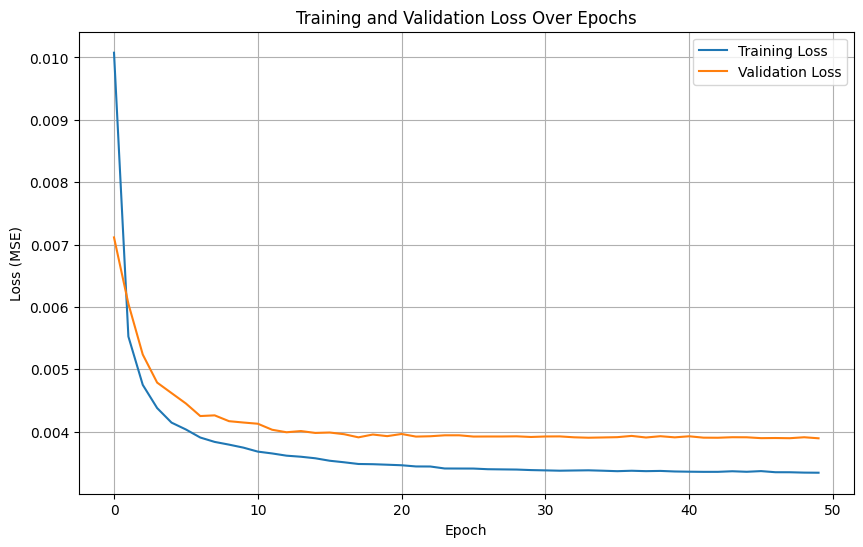

In [78]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
# Inference on test set with batch prediction
y_pred_scaled = bilstm_model.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensuring predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/bilstm_model_48seq.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/bilstm_model_48seq.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/bilstm_model_48seq.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 10:00:00, Predicted PM2.5 = 73
Sample 2: Datetime = 2013-07-02 11:00:00, Predicted PM2.5 = 66
Sample 3: Datetime = 2013-07-02 12:00:00, Predicted PM2.5 = 60
Sample 4: Datetime = 2013-07-02 13:00:00, Predicted PM2.5 = 57
Sample 5: Datetime = 2013-07-02 14:00:00, Predicted PM2.5 = 55


# Model 6 : Bidirectional LSTM Model `with Sequence Length 48 and Early Stopping`

In [80]:
# A Bidirectional LSTM model
def bilstm_model_2(n_features, seq_length=48):
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh', kernel_initializer=tf.keras.initializers.LecunNormal(seed=21)))(input_layer)
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh'))(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    output_last = lstm_out[:, -1, :]
    final_output = Dense(1, activation='sigmoid')(output_last)

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00001), loss='mse')
    # Display model architecture
    model.summary()
    return model

In [81]:
# Calculating the Root Mean Squared Error (RMSE)
def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [82]:
# Preprocessing the data
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=48)

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148


In [83]:
# Adding callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [84]:
# Build and train the model
bilstm_model2 = bilstm_model_2(n_features=X_train_seq.shape[2], seq_length=48)
history = bilstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50, batch_size=32, verbose=1,
    callbacks=[lr_scheduler, early_stopping] # Include early stopping
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 48, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 48, 100)        │        24,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 48, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item_5 (GetItem)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,901 (331.64 KB)

 Trainable params: 84,701 (330.86 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 66s 87ms/step - loss: 0.0034 - val_loss: 0.0039 - learning_rate: 1.0000e-06
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 80s 85ms/step - loss: 0.0033 - val_loss: 0.0039 - learning_rate: 1.0000e-06
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 83s 86ms/step - loss: 0.0033 - val_loss: 0.0039 - learning_rate: 1.0000e-06
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 83s 86ms/step - loss: 0.0032 - val_loss: 0.0039 - learning_rate: 1.0000e-06
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 66s 86ms/step - loss: 0.0034 - val_loss: 0.0039 - learning_rate: 1.0000e-06
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 68s 89ms/step - loss: 0.0033 - val_loss: 0.0039 - learning_rate: 1.0000e-06
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - loss: 0.0033 - val_loss: 0.0039 - learning_rate: 1.0000e-06
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - loss: 0.0033 - val_loss: 0.0039 - learning_rate: 1.0000e-06
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 80s 87ms/step - loss: 0.0034 - v

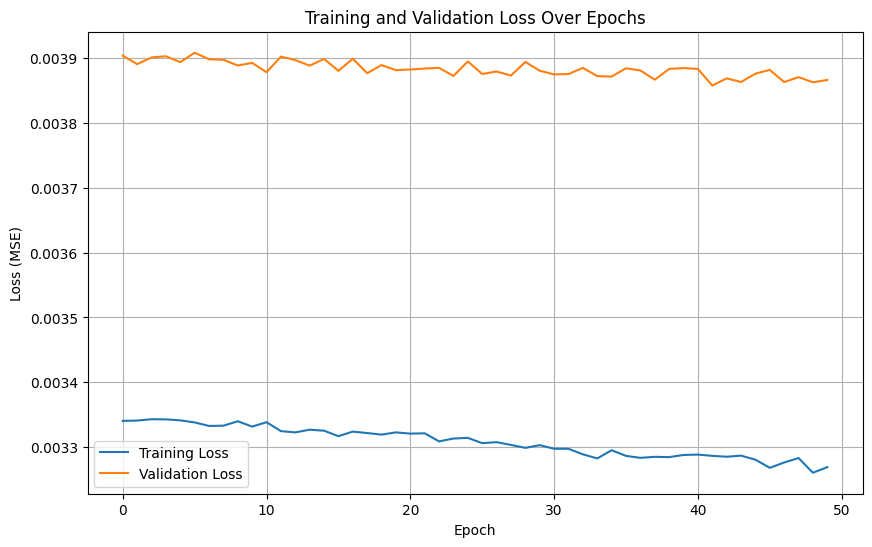

In [85]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
# Inference on test set with batch prediction
y_pred_scaled = bilstm_model2.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensuring predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/bilstm_model_48seq_earlystopping.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/bilstm_model_48seq_earlystopping.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/bilstm_model_48seq_earlystopping.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 10:00:00, Predicted PM2.5 = 405
Sample 2: Datetime = 2013-07-02 11:00:00, Predicted PM2.5 = 402
Sample 3: Datetime = 2013-07-02 12:00:00, Predicted PM2.5 = 400
Sample 4: Datetime = 2013-07-02 13:00:00, Predicted PM2.5 = 398
Sample 5: Datetime = 2013-07-02 14:00:00, Predicted PM2.5 = 397


# Model 7 : Bidirectional LSTM Model `with Sequence Length 24 and Early Stopping`

In [93]:
# Build Bidirectional LSTM model
def bilstm_model_3(n_features, seq_length=24):
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = Bidirectional(LSTM(25, return_sequences=True, activation='tanh', kernel_initializer=tf.keras.initializers.LecunNormal(seed=21)))(input_layer)
    lstm_out = Bidirectional(LSTM(35, return_sequences=True, activation='tanh'))(lstm_out)
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh'))(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    output_last = lstm_out[:, -1, :]
    final_output = Dense(1, activation='sigmoid')(output_last)

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001), loss='mse')
    # Display model architecture
    model.summary()
    return model

In [94]:
# Calculating the Root Mean Squared Error (RMSE)
def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [95]:
# Preprocessing the data
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=24)

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148


In [96]:
# Adding callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [97]:
# Build and train the model
bilstm_model3 = bilstm_model_3(n_features=X_train_seq.shape[2], seq_length=24)
history = bilstm_model3.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=70, batch_size=32, verbose=1,
    callbacks=[lr_scheduler, early_stopping] # Include early stopping
)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 24, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 24, 50)         │         7,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 24, 70)         │        24,080 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 24, 100)        │        48,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item_8 (GetItem)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,981 (312.43 KB)

 Trainable params: 79,781 (311.64 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 56s 60ms/step - loss: 0.0215 - val_loss: 0.0048 - learning_rate: 1.0000e-04
Epoch 2/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - loss: 0.0041 - val_loss: 0.0042 - learning_rate: 1.0000e-04
Epoch 3/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - loss: 0.0042 - val_loss: 0.0041 - learning_rate: 1.0000e-04
Epoch 4/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 83s 63ms/step - loss: 0.0037 - val_loss: 0.0043 - learning_rate: 1.0000e-04
Epoch 5/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 78s 58ms/step - loss: 0.0038 - val_loss: 0.0041 - learning_rate: 1.0000e-04
Epoch 6/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 83s 60ms/step - loss: 0.0039 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 7/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 84s 63ms/step - loss: 0.0037 - val_loss: 0.0041 - learning_rate: 1.0000e-04
Epoch 8/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - loss: 0.0036 - val_loss: 0.0042 - learning_rate: 1.0000e-04
Epoch 9/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 80s 60ms/step - loss: 0.0036 - v

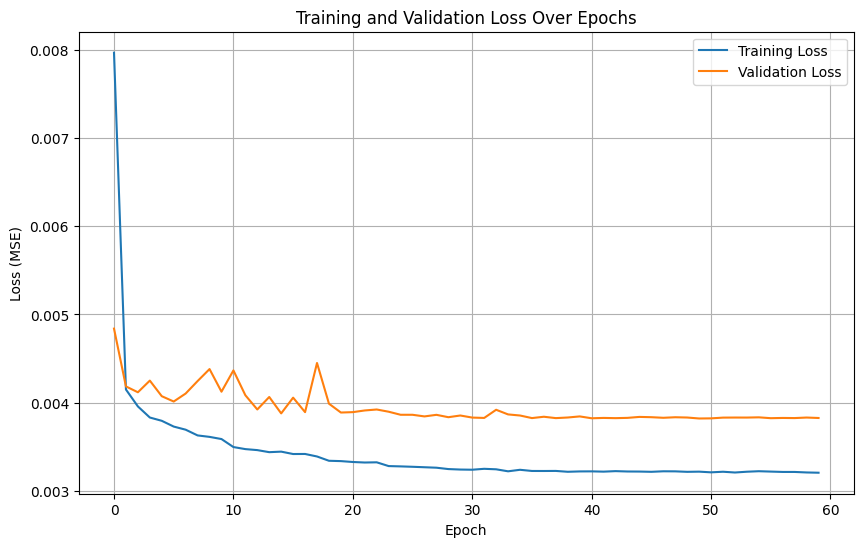

In [98]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
# Inference on test set with batch prediction
y_pred_scaled = bilstm_model3.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensuring predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/bilstm_model_24seq_earlystopping.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/bilstm_model_24seq_earlystopping.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/bilstm_model_24seq_earlystopping.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 10:00:00, Predicted PM2.5 = 39
Sample 2: Datetime = 2013-07-02 11:00:00, Predicted PM2.5 = 28
Sample 3: Datetime = 2013-07-02 12:00:00, Predicted PM2.5 = 23
Sample 4: Datetime = 2013-07-02 13:00:00, Predicted PM2.5 = 23
Sample 5: Datetime = 2013-07-02 14:00:00, Predicted PM2.5 = 21


# Model 8 : Bidirectional LSTM Model `with Sequence Length 48 (using preprocess_data_2)`

In [28]:
# Preprocess data function
def preprocess_data_2(X_train, y_train, X_test, seq_length=48, val_split=0.2):
    """
    Preprocessing the time series data by scaling features and targets, creating sequences.
    """
    # Extracting datetime index
    train_datetime = X_train.index if isinstance(X_train, pd.DataFrame) else None
    test_datetime = X_test.index if isinstance(X_test, pd.DataFrame) else None

    # Converting to NumPy arrays and drop datetime index if present
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()

    # Check and align lengths of X_train and y_train
    if len(X_train) != len(y_train):
        print(f"Warning: Length mismatch between X_train ({len(X_train)}) and y_train ({len(y_train)}).")
        min_len = min(len(X_train), len(y_train))
        X_train = X_train[:min_len]
        y_train = y_train[:min_len]
        if train_datetime is not None:
            train_datetime = train_datetime[:min_len]
    else:
        print(f"X_train and y_train lengths are consistent: {len(X_train)} samples.")

    # Initialize scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Scaling input features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scaling target values
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

    # Creating training sequences
    n_features = X_train_scaled.shape[1]
    train_sequences = []
    train_targets = []
    for i in range(len(X_train_scaled) - seq_length + 1):
        seq = X_train_scaled[i:i + seq_length]
        target = y_train_scaled[i + seq_length - 1]  # Target is y at the end of sequence
        train_sequences.append(seq)
        train_targets.append(target)
    train_sequences = np.array(train_sequences)
    train_targets = np.array(train_targets)

    # Splitting training sequences into train and validation
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
        train_sequences, train_targets, test_size=val_split, random_state=42, shuffle=False
    )

    # Preparing test sequences
    X_combined_scaled = np.vstack((X_train_scaled[-(seq_length-1):], X_test_scaled))
    n_test = len(X_test_scaled)
    X_test_seq = []
    for i in range(n_test):
        start_idx = i
        end_idx = i + seq_length
        if end_idx <= len(X_combined_scaled):  # Ensure no index out of bounds
            X_test_seq.append(X_combined_scaled[start_idx:end_idx])
    X_test_seq = np.array(X_test_seq)

    # Validate lengths
    if len(X_test_seq) != len(X_test_scaled):
        raise ValueError(f"Mismatch between test sequences ({len(X_test_seq)}) and X_test ({len(X_test_scaled)}).")
    print(f"Number of test sequences: {len(X_test_seq)}")
    print(f"Number of test datetimes: {len(test_datetime)}" if test_datetime is not None else "No test datetimes available")

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetime, scaler_X, scaler_y


In [29]:
# A Bidirectional LSTM model
def bilstm_model_4(n_features, seq_length=48):
    input_layer = Input(shape=(seq_length, n_features))
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh', kernel_initializer=tf.keras.initializers.LecunNormal(seed=21)))(input_layer)
    lstm_out = Bidirectional(LSTM(50, return_sequences=True, activation='tanh'))(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    output_last = lstm_out[:, -1, :]
    final_output = Dense(1, activation='sigmoid')(output_last)

    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00001), loss='mse')
    # Display model architecture
    model.summary()
    return model

In [30]:
# Calculating the Root Mean Squared Error (RMSE)
def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [31]:
# Preprocessing the data
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data_2(
    X_train, y_train, X_test, seq_length=48
)

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148


In [32]:
# Adding callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [37]:
# Build and train the Bidirectional LSTM model
bilstm_model4 = bilstm_model_4(n_features=X_train_seq.shape[2], seq_length=48)
history_bilstm = bilstm_model4.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 48, 100)        │        24,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 48, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item_1 (GetItem)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,901 (331.64 KB)

 Trainable params: 84,701 (330.86 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 78s 92ms/step - loss: 0.0195 - val_loss: 0.0068 - learning_rate: 1.0000e-05
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - loss: 0.0060 - val_loss: 0.0058 - learning_rate: 1.0000e-05
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 68s 89ms/step - loss: 0.0050 - val_loss: 0.0051 - learning_rate: 1.0000e-05
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - loss: 0.0044 - val_loss: 0.0047 - learning_rate: 1.0000e-05
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 68s 89ms/step - loss: 0.0043 - val_loss: 0.0045 - learning_rate: 1.0000e-05
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 68s 89ms/step - loss: 0.0040 - val_loss: 0.0044 - learning_rate: 1.0000e-05
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 87s 95ms/step - loss: 0.0039 - val_loss: 0.0042 - learning_rate: 1.0000e-05
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - loss: 0.0037 - val_loss: 0.0041 - learning_rate: 1.0000e-05
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 76s 88ms/step - loss: 0.0038 - v

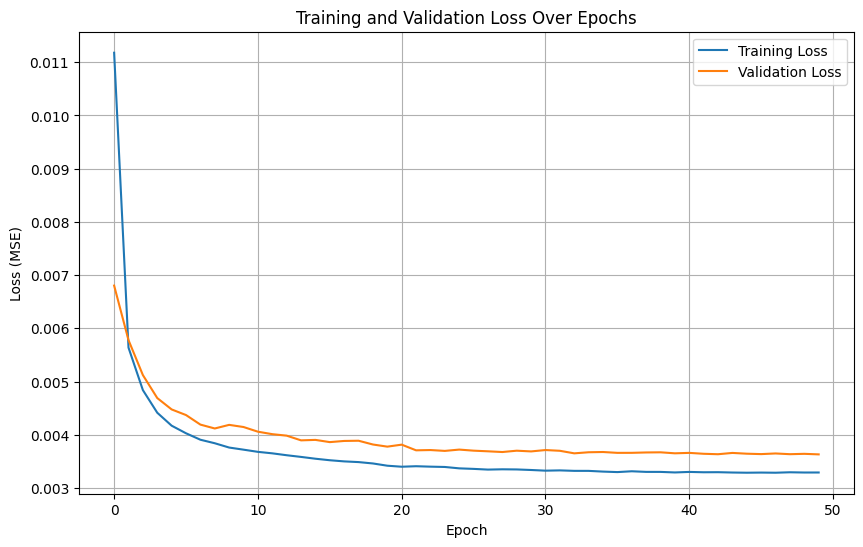

In [39]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Inference on test set with batch prediction
y_pred_scaled = bilstm_model4.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensuring predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/bilstm_model_48seq_preprocess2.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/bilstm_model_24seq_preprocess2.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/bilstm_model_24seq_preprocess2.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 10:00:00, Predicted PM2.5 = 38
Sample 2: Datetime = 2013-07-02 11:00:00, Predicted PM2.5 = 35
Sample 3: Datetime = 2013-07-02 12:00:00, Predicted PM2.5 = 36
Sample 4: Datetime = 2013-07-02 13:00:00, Predicted PM2.5 = 38
Sample 5: Datetime = 2013-07-02 14:00:00, Predicted PM2.5 = 41


# Model 9 : `Bidirectional LSTM Model with Attention` (Sequence Length 24)

In [46]:
# A Bidirectional LSTM with Attention model
def bilstm_attention_model(n_features, seq_length=24):
    """
    A Bidirectional LSTM model with Multi-Head Attention to predict scaled PM2.5.
    """
    input_layer = Input(shape=(seq_length, n_features))

    # First Bidirectional LSTM layer
    lstm1 = Bidirectional(LSTM(64,
                              activation='tanh',
                              return_sequences=True,
                              dropout=0.25,
                              recurrent_dropout=0.15))(input_layer)

    # Second Bidirectional LSTM layer
    lstm2 = Bidirectional(LSTM(32,
                              activation='tanh',
                              return_sequences=True,
                              dropout=0.25,
                              recurrent_dropout=0.15))(lstm1)

    # Multi-Head Attention Layer
    attention_out = MultiHeadAttention(
        num_heads=4,
        key_dim=16,
        dropout=0.1
    )(lstm2, lstm2)

    # Residual connection + Layer Normalization
    x = Add()([lstm2, attention_out])
    x = LayerNormalization()(x)

    # Final LSTM layer to process attention output
    final_lstm = Bidirectional(LSTM(16,
                                   activation='tanh',
                                   return_sequences=False,
                                   dropout=0.2))(x)

    # Dense layers for final prediction
    x = Dense(24, activation='relu')(final_lstm)
    x = Dropout(0.15)(x)
    # Final output layer with sigmoid activation for scaled target
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001), loss='mse')

    # Display the model architecture
    model.summary()

    return model

In [47]:
# Calculating the Root Mean Squared Error (RMSE)
def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) for evaluation or submission.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [48]:
# Adding callback for learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [49]:
# Preprocessing the data
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, test_datetimes, scaler_X, scaler_y = preprocess_data(
    X_train, y_train, X_test, seq_length=24)

X_train and y_train lengths are consistent: 30676 samples.
Number of test sequences: 13148
Number of test datetimes: 13148


In [50]:
# Build and train the Bidirectional LSTM with Attention model
model_attention = bilstm_attention_model(n_features=X_train_seq.shape[2], seq_length=24)
history_attention = model_attention.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 24, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 24, 128)   │     37,888 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 24, 64)    │     41,216 │ bidirectional_7[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 64)    │     16,640 │ bidirectional_8[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 64)    │          0 │ bidirectional_8[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 32)        │     10,368 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 24)        │        792 │ bidirectional_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         25 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 107,057 (418.19 KB)

 Trainable params: 107,057 (418.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 126s 135ms/step - loss: 0.0183 - val_loss: 0.0066 - learning_rate: 1.0000e-04
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 137s 128ms/step - loss: 0.0066 - val_loss: 0.0060 - learning_rate: 1.0000e-04
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 145s 133ms/step - loss: 0.0060 - val_loss: 0.0057 - learning_rate: 1.0000e-04
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 138s 128ms/step - loss: 0.0058 - val_loss: 0.0057 - learning_rate: 1.0000e-04
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 98s 128ms/step - loss: 0.0056 - val_loss: 0.0056 - learning_rate: 1.0000e-04
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 142s 128ms/step - loss: 0.0054 - val_loss: 0.0056 - learning_rate: 1.0000e-04
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 140s 125ms/step - loss: 0.0054 - val_loss: 0.0055 - learning_rate: 1.0000e-04
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 144s 128ms/step - loss: 0.0054 - val_loss: 0.0054 - learning_rate: 1.0000e-04
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 97s 127ms/step - 

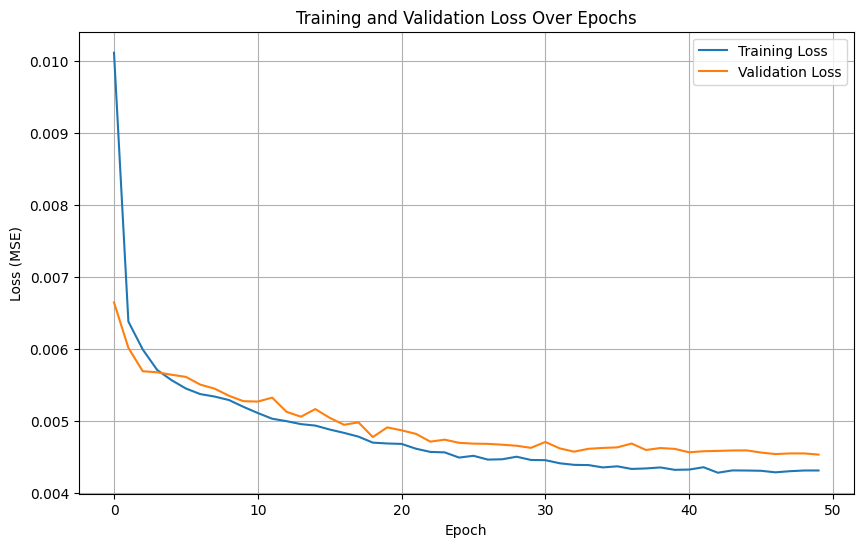

In [51]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_attention.history['loss'], label='Training Loss')
plt.plot(history_attention.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Inference on test set with batch prediction
y_pred_scaled = model_attention.predict(X_test_seq, verbose=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Ensuring predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(y_pred)
predictions = np.maximum(predictions, 0)  # Prevent negative values
predictions = np.round(predictions).astype(int)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test_datetimes).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/model_attention.csv', index=False)
print("Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/model_attention.csv'")

# Output first few predictions for verification
print("Sample predictions for submission:")
for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}: Datetime = {submission['row ID'].iloc[i]}, Predicted PM2.5 = {predictions[i][0]}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step
Submission CSV saved as '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/model_attention.csv'
Sample predictions for submission:
Sample 1: Datetime = 2013-07-02 10:00:00, Predicted PM2.5 = 61
Sample 2: Datetime = 2013-07-02 11:00:00, Predicted PM2.5 = 55
Sample 3: Datetime = 2013-07-02 12:00:00, Predicted PM2.5 = 51
Sample 4: Datetime = 2013-07-02 13:00:00, Predicted PM2.5 = 47
Sample 5: Datetime = 2013-07-02 14:00:00, Predicted PM2.5 = 44
